In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('dish_washer.csv')

In [5]:
df_copy = df.copy()
df_copy.drop(['model_code'], axis=1, inplace=True)
categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
df_copy.shape

(77, 11)

one hot encoding

In [6]:
df_copy = pd.get_dummies(df_copy, columns=categorical_cols)

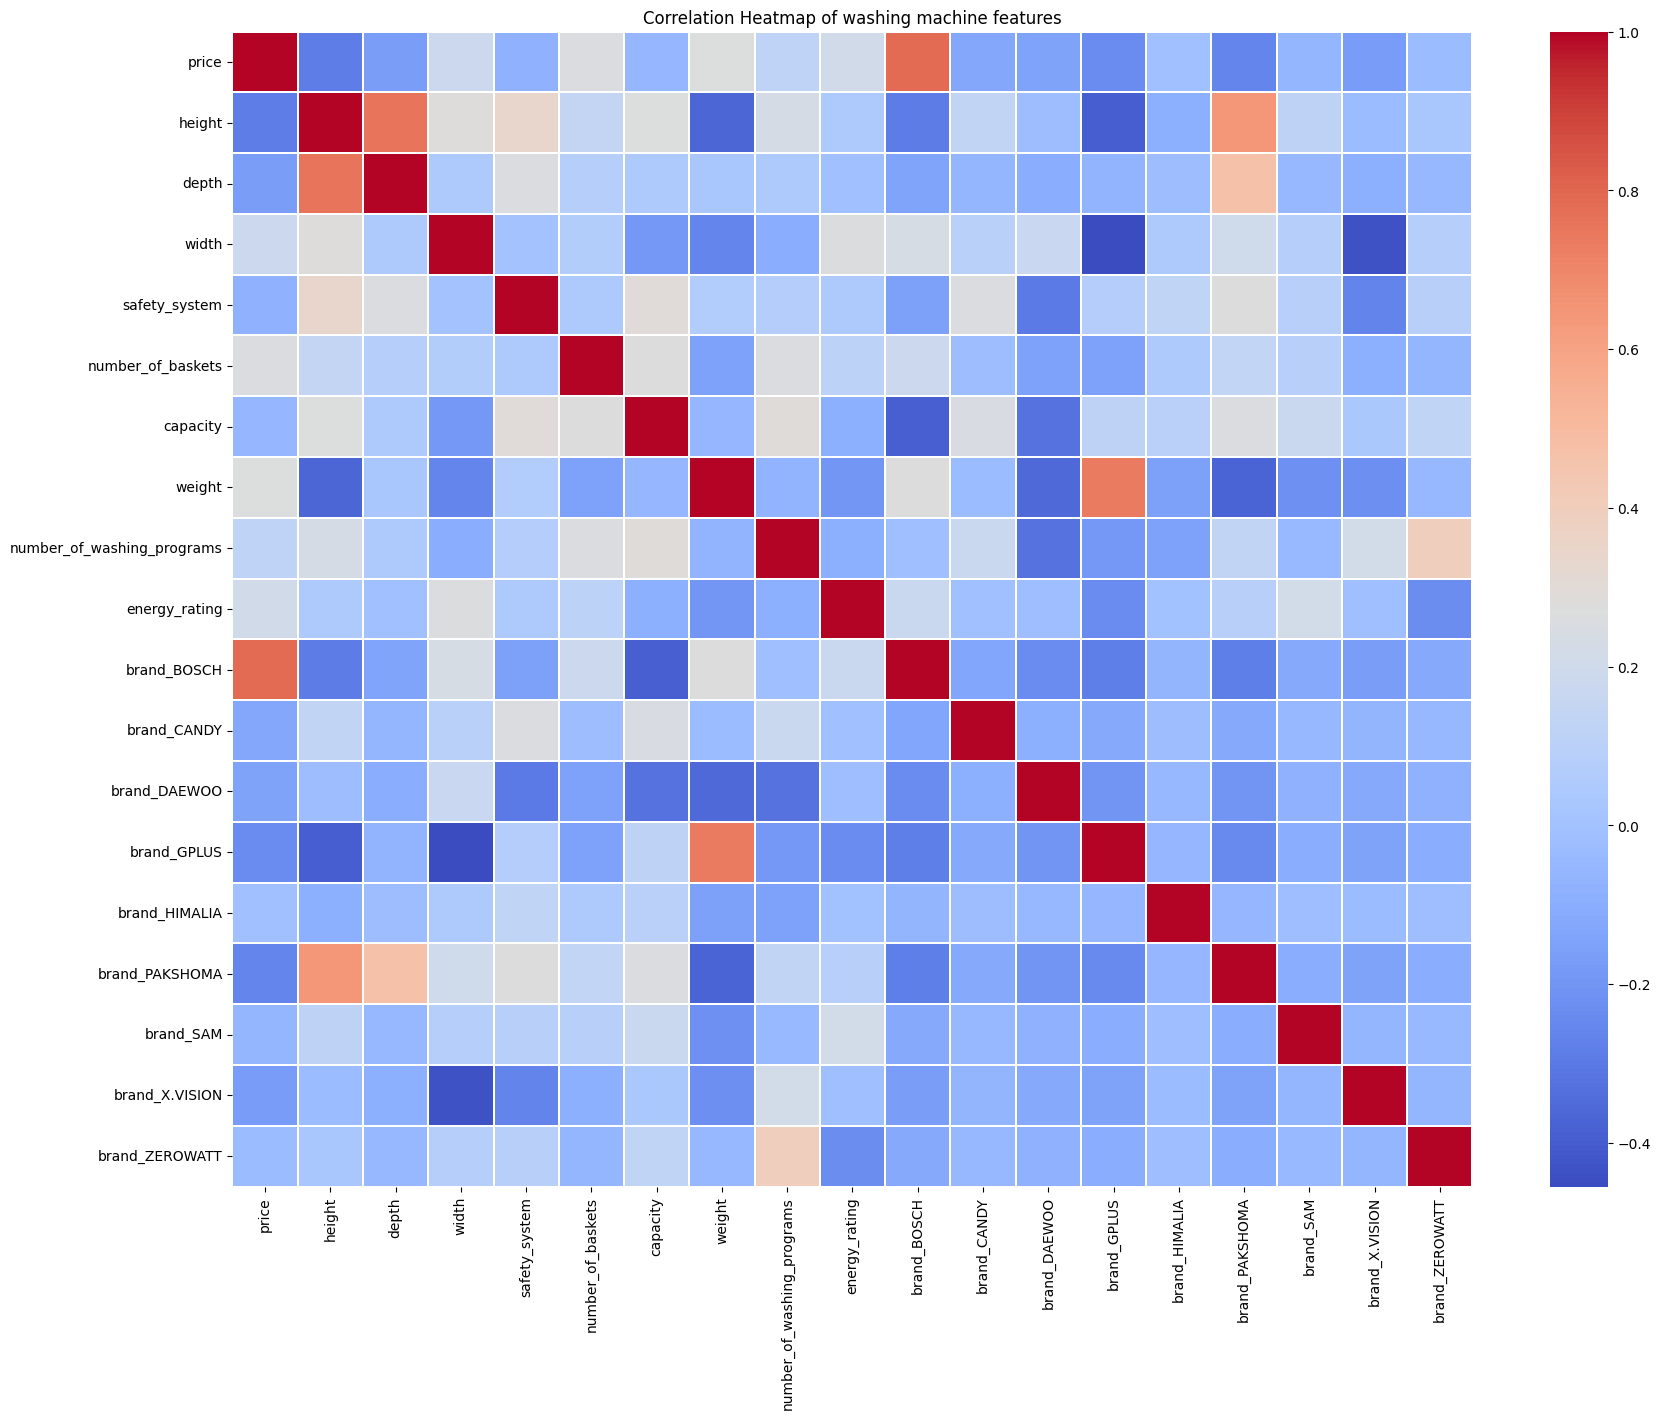

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_copy.corr()

# Plot the heatmap

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix,annot=False, cmap='coolwarm', linewidths=0.2)

# Title
plt.title("Correlation Heatmap of washing machine features")

# Show plot
plt.show()


remove high corrolated feature

In [8]:
threshold = 0.8
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns 
          if any((upper_tri[column] > threshold) | (upper_tri[column] < -threshold))]

# Drop the highly correlated columns
wm_cleaned = df_copy.drop(columns=[col for col in to_drop if col in df_copy.columns])

print(f"Dropped columns: {to_drop}")
# print(f"Original shape: {wm.shape}")
print(f"New shape: {wm_cleaned.shape}")
# wm_cleaned = df_copy

Dropped columns: []
New shape: (77, 19)


 Feature Selection Based on Variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
selected_features = selector.fit_transform(wm_cleaned)
# Get selected feature names
selected_feature_names = wm_cleaned.columns[selector.get_support()]
#Convert back to DataFrame
wm_selected = pd.DataFrame(selected_features, columns=selected_feature_names)


In [ ]:
# wm_selected['brand_BOSCH'] = df_copy['brand_BOSCH']
# wm_selected = pd.get_dummies(wm_selected, columns=['brand_BOSCH'],drop_first=True)

In [11]:
wm_selected.shape

(77, 12)

clustering

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Assuming df is your dataframe
scaler =MinMaxScaler()
# scaler =StandardScaler()
df_scaled = scaler.fit_transform(wm_selected)


kmeans

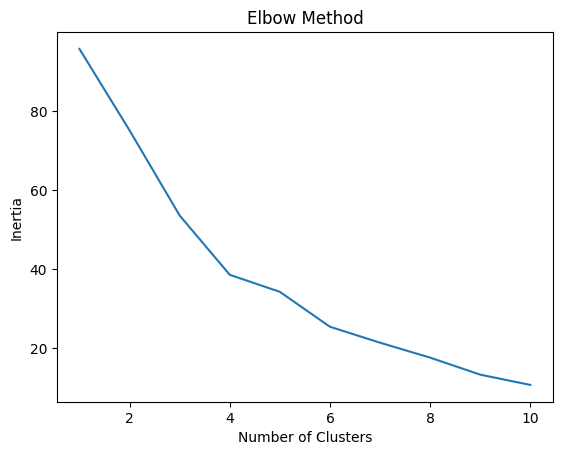

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_kmeans(data, k_range):
    best_k = None
    best_score = -1
    best_metrics = {}
    best_k_labels=None

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, labels)
        calinski_harabasz_avg = calinski_harabasz_score(data, labels)
        davies_bouldin_avg = davies_bouldin_score(data, labels)
        
        # Combine the scores into a single metric for comparison
        combined_score = silhouette_avg + calinski_harabasz_avg - davies_bouldin_avg
        
        if combined_score > best_score:
            best_score = combined_score
            best_k = k
            best_metrics = {
                'silhouette_score': silhouette_avg,
                'calinski_harabasz_score': calinski_harabasz_avg,
                'davies_bouldin_score': davies_bouldin_avg
            }
            best_k_labels = labels
            wm_selected['kmean_cluster']=best_k_labels
            centroids = kmeans.cluster_centers_
    
    return best_k, best_metrics,best_k_labels,centroids

# Define the range of k values to search
k_range = range(2, 5)


# Evaluate KMeans clustering
best_k, best_metrics,kmean_labels,centroids = evaluate_kmeans(df_scaled, k_range)

print(f"Best k: {best_k}")
print(f"Best metrics: {best_metrics}")

Best k: 4
Best metrics: {'silhouette_score': np.float64(0.36813317335132456), 'calinski_harabasz_score': np.float64(28.686930595715225), 'davies_bouldin_score': np.float64(1.2330046435102693)}


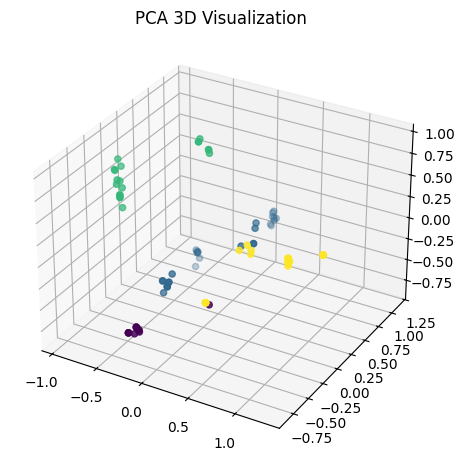

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=6)
pca_result = pca.fit_transform(df_scaled)

# Perform t-SNE to reduce dimensions to 3
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(df_scaled)

# Plot PCA result
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=wm_selected['kmean_cluster'], marker='o')
ax.set_title('PCA 3D Visualization')


plt.show()

In [18]:
print(pca.explained_variance_ratio_)  # Importance of each component
pca_comp = pca.components_  # Contribution of each feature

# Get top 5 absolute values for each component
top_5_indices = np.argsort(-np.abs(pca_comp), axis=1)[:, :5]  # Sort and take top 5

print(top_5_indices)

[0.28773865 0.23635328 0.1943713  0.10160086 0.05677245 0.0409886 ]
[[ 3 11  8  1  6]
 [10  6  3  9 11]
 [ 8 10  9  3  0]
 [ 3 11  9 10  2]
 [ 9  2  6  1  7]
 [ 4  2  1 11  9]]


In [19]:
important_cols_pca1 = wm_selected.columns[top_5_indices[0]]
print(important_cols_pca1)
important_cols_pca2 = wm_selected.columns[top_5_indices[1]]
print(important_cols_pca2)
important_cols_pca3 = wm_selected.columns[top_5_indices[2]]
print(important_cols_pca3)

Index(['safety_system', 'brand_PAKSHOMA', 'brand_BOSCH', 'height', 'weight'], dtype='object')
Index(['brand_GPLUS', 'weight', 'safety_system', 'brand_DAEWOO',
       'brand_PAKSHOMA'],
      dtype='object')
Index(['brand_BOSCH', 'brand_GPLUS', 'brand_DAEWOO', 'safety_system', 'price'], dtype='object')


In [20]:
sample_counts = wm_selected.groupby('kmean_cluster').size()
print(sample_counts)

kmean_cluster
0    11
1    28
2    19
3    19
dtype: int64


In [22]:
wm_selected.columns

Index(['price', 'height', 'depth', 'safety_system', 'number_of_baskets',
       'capacity', 'weight', 'number_of_washing_programs', 'brand_BOSCH',
       'brand_DAEWOO', 'brand_GPLUS', 'brand_PAKSHOMA', 'kmean_cluster'],
      dtype='object')

In [24]:
import pandas as pd
numeric_cols = ['price', 'height', 'depth', 'safety_system', 'number_of_baskets',
       'capacity', 'weight', 'number_of_washing_programs']
# Group by cluster
cluster_summary = wm_selected.groupby('kmean_cluster')[numeric_cols].mean(numeric_only=True)  # Mean for numerical data

# Mode for categorical data
categorical_columns = ['brand_BOSCH','brand_DAEWOO', 'brand_GPLUS', 'brand_PAKSHOMA']  # List your categorical columns
mode_summary = wm_selected.groupby('kmean_cluster')[categorical_columns].agg(lambda x: x.mode().iloc[0])

# Combine both summaries
final_summary = cluster_summary.join(mode_summary)

print("Cluster Summary Statistics:\n", final_summary)
# print("\nMode Summary:\n", mode_summary)


Cluster Summary Statistics:
                       price     height      depth  safety_system  \
kmean_cluster                                                      
0              3.147610e+07  84.771429  60.000000       0.090909   
1              3.014843e+07  84.660714  60.057143       0.464286   
2              5.247267e+07  84.607143  60.000000       0.315789   
3              2.988284e+07  85.184211  61.263158       0.789474   

               number_of_baskets   capacity     weight  \
kmean_cluster                                            
0                       2.636364  12.727273  46.428571   
1                       2.678571  14.321429  55.982143   
2                       2.947368  12.894737  55.307143   
3                       2.947368  14.631579  46.639098   

               number_of_washing_programs  brand_BOSCH  brand_DAEWOO  \
kmean_cluster                                                          
0                                6.636364          0.0           1.0 

/tmp/ipykernel_73437/1151441868.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_summary_transposed_rounded = final_summary_transposed.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


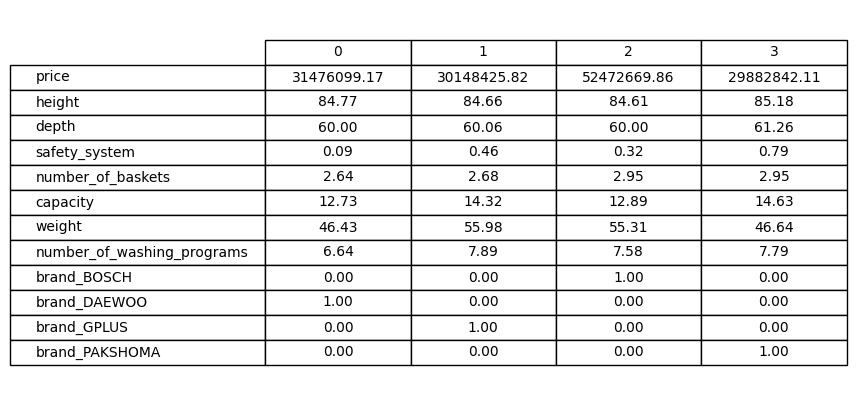

In [25]:
import numpy as np
final_summary_transposed = final_summary.T
# Round the values in final_summary_transposed to two decimal places
final_summary_transposed_rounded = final_summary_transposed.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

# Create a figure and axes object for displaying the matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Adjusted width and height for better fit

# Display the transposed matrix using matplotlib's table functionality
ax.axis('off')  # Turn off the axis
table = ax.table(cellText=final_summary_transposed_rounded.values,
                 colLabels=final_summary_transposed_rounded.columns,
                 rowLabels=final_summary_transposed_rounded.index,
                 cellLoc='center',
                 loc='center')

# Adjust font size for better readability
table.auto_set_font_size(False)
table.set_fontsize(10)  # You can adjust the font size here
table.scale(1.5, 1.5)  # Scale the table for better visibility

plt.show()


Cluster Centroids (Rounded):
 [[ 0.26  0.18  0.03  0.09  0.82  0.67  0.18  0.23 -0.    1.    0.    0.  ]
 [ 0.24  0.11  0.04  0.46  0.84  0.83  0.68  0.41 -0.    0.    0.54  0.  ]
 [ 0.64  0.07  0.03  0.32  0.97  0.69  0.65  0.37  1.    0.    0.    0.  ]
 [ 0.23  0.46  0.24  0.79  0.97  0.86  0.19  0.4  -0.    0.    0.    0.79]]


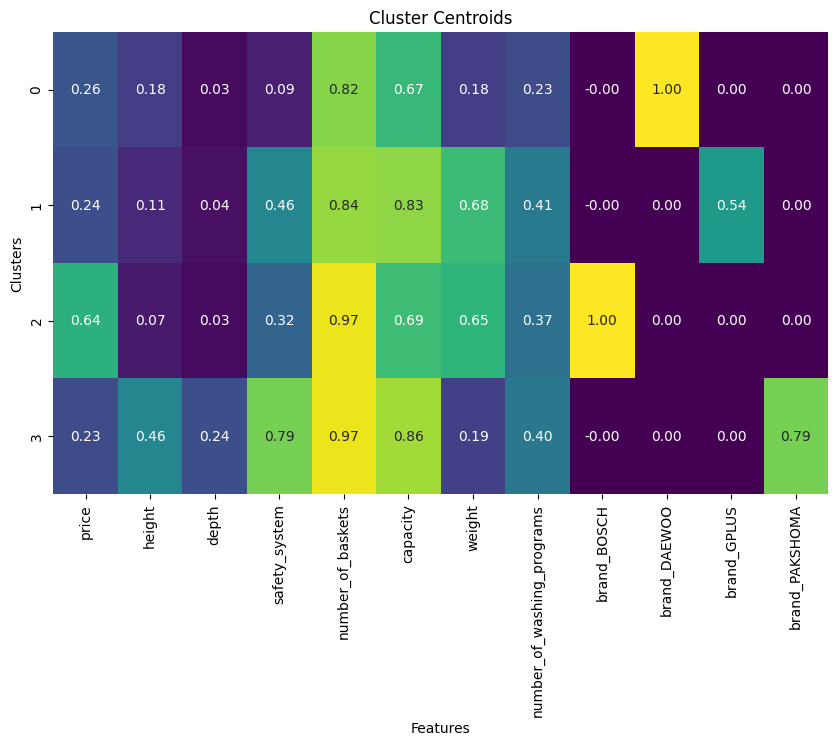

In [35]:
# Print the centroids to compare across clusters
# print("Cluster Centroids:\n", centroids)

# Optionally, display them more neatly
centroids = centroids.round(2)  # Round the values for easier reading
print("Cluster Centroids (Rounded):\n", centroids)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the centroids as a heatmap for easy comparison
plt.figure(figsize=(10, 6))
sns.heatmap(centroids, annot=True, cmap='viridis', fmt='.2f', cbar=False, xticklabels=wm_selected.columns[:-1])
plt.title('Cluster Centroids')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()


In [27]:
df['kmean_cluster']=kmean_labels

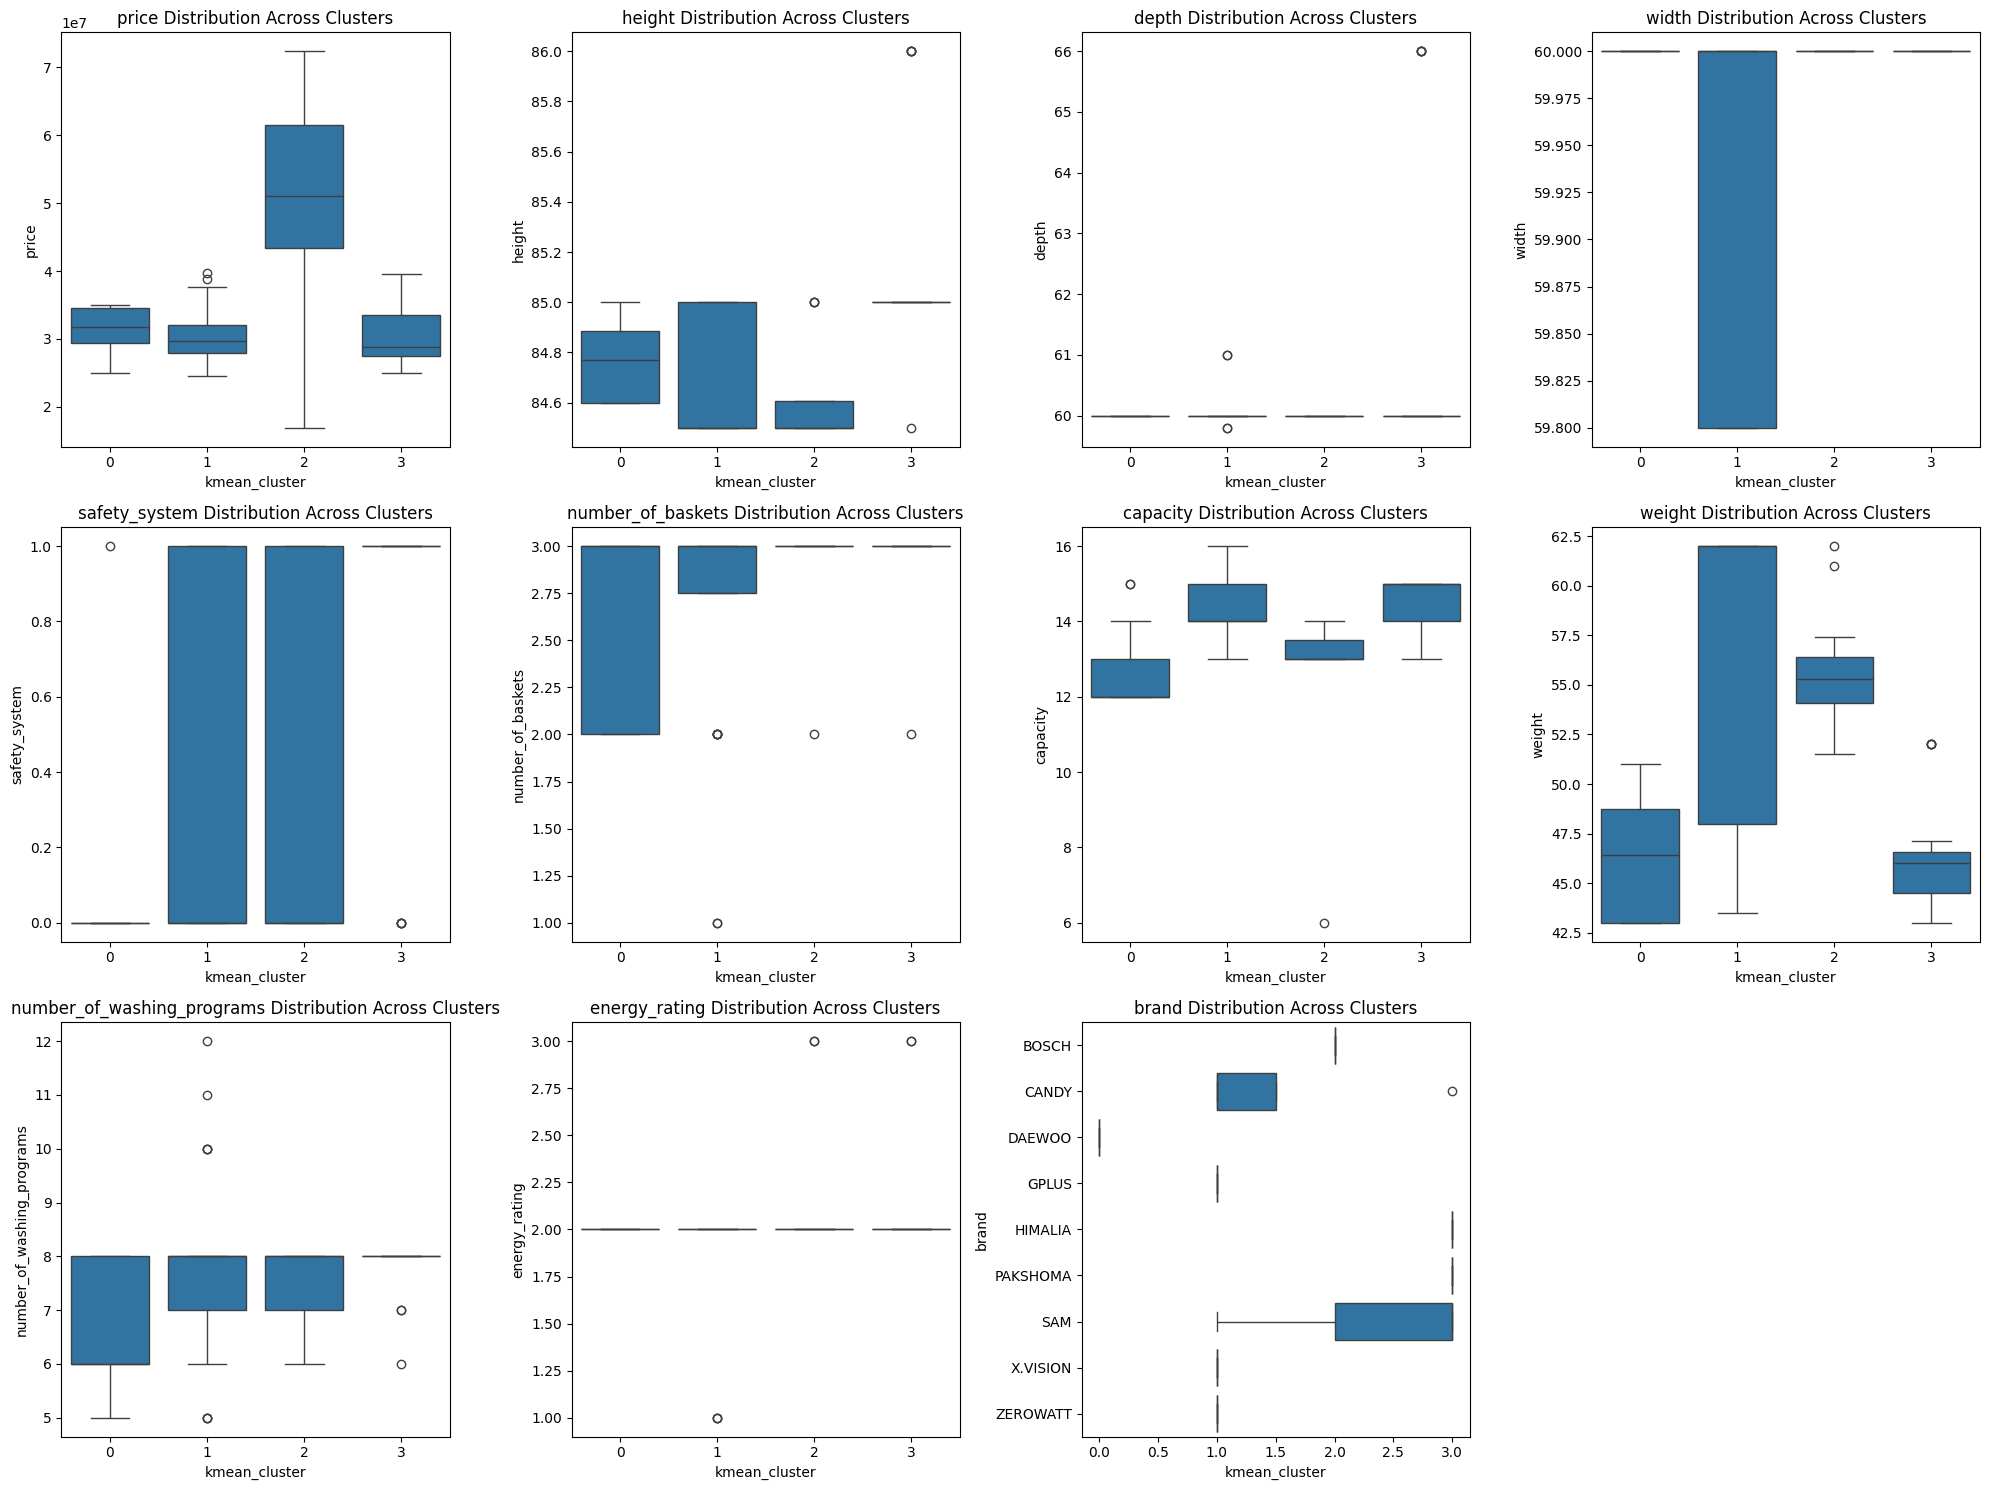

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features to plot
features_to_plot = df.columns[1:-1]  # Exclude the cluster label
num_features = len(features_to_plot)

# Determine the number of rows and columns
num_rows = 3
num_cols = (num_features // num_rows) + (num_features % num_rows > 0)  # Calculate the columns required

# Create a subplot with enough space for all features
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each feature and create a boxplot in the corresponding subplot
for idx, feature in enumerate(features_to_plot):
    sns.boxplot(x='kmean_cluster', y=feature, data=df, ax=axes[idx])
    axes[idx].set_title(f'{feature} Distribution Across Clusters')

# Remove empty subplots if any
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

# Display the plot
plt.tight_layout()
plt.show()


Index(['model_code', 'brand'], dtype='object')


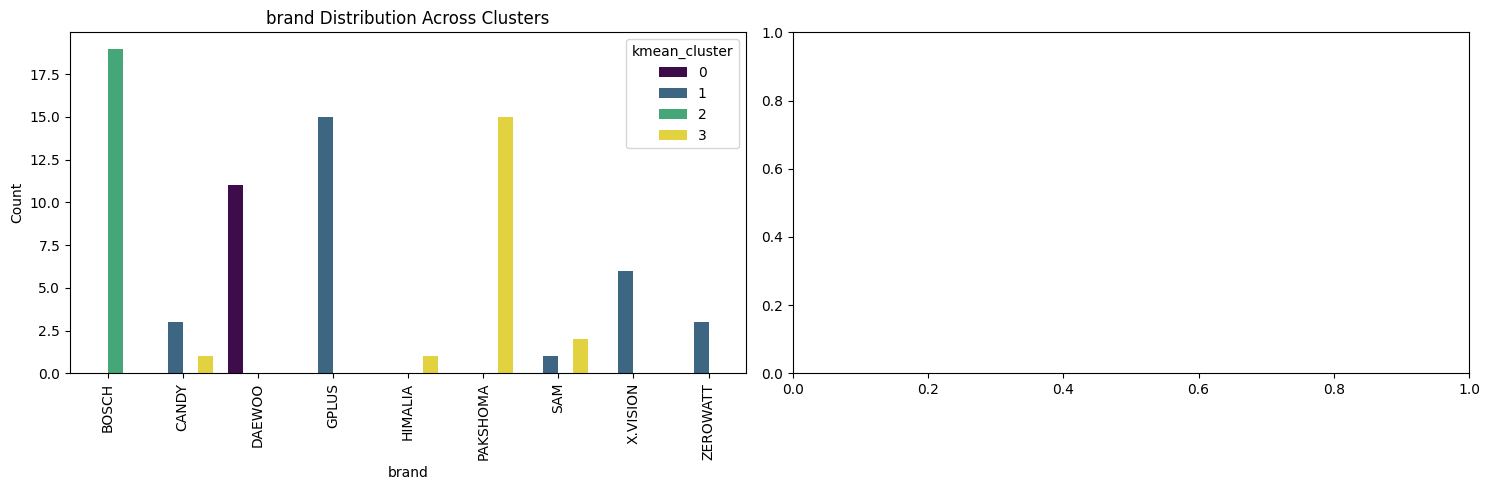

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical features to compare
categorical_features = df.select_dtypes(include=['object', 'category']).columns  # Automatically select categorical columns
print(categorical_features)
categorical_features = categorical_features[1:]
# Number of subplots (rows and columns)
n_cols = 2  # Set the number of columns for subplots (adjust as needed)
n_rows = (len(categorical_features) // n_cols) + (1 if len(categorical_features) % n_cols > 0 else 0)

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through categorical features and plot them in subplots
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='kmean_cluster', data=df, palette='viridis', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution Across Clusters')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels by 90 degrees

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
